# Import Libraries and Data

In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import re
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
#nltk.download('wordnet') 
from nltk.stem.wordnet import WordNetLemmatizer
import wordcloud
import glob
import plotly.offline as py

In [2]:
# df = pd.DataFrame()
li = []
for file in glob.glob('./data/*.csv'):
    df_temp = pd.read_csv(file)
    li.append(df_temp)
    
df = pd.concat(li, axis=0, ignore_index=True)

In [3]:
df.shape

(4297, 8)

In [4]:
df.head()

,Unnamed: 0,url,title,company,date_posted,geo_coord,industry,job_description
0,0,https://www.glassdoor.com/partner/jobListing.h...,True Tech Data Analyst Intern,Bambu,2019-11-08,"('1.2931', '103.8558')",Finance,"<div class=""jobDesc"" id=""JobDesc3410231829""><d..."
1,1,https://www.glassdoor.com/partner/jobListing.h...,"Senior Data Analyst – Data Hub, Strategic Comm...",Vital,2019-11-28,"('1.2931', '103.8558')",Government,"<div class=""jobDesc"" id=""JobDesc3426998789""><d..."
2,2,https://www.glassdoor.com/partner/jobListing.h...,Data Analyst Lead - Key Reports & Finance,Shopee,2019-11-26,"('1.2931', '103.8558')",Information Technology,"<div class=""jobDesc"" id=""JobDesc3195280427""><d..."
3,3,https://www.glassdoor.com/partner/jobListing.h...,Data Analyst,Straits Marine Supply Pte. Ltd.,2019-11-16,"('1.3214', '103.6567')",empty,"<div class=""jobDesc"" id=""JobDesc3306625098""><d..."
4,4,https://www.glassdoor.com/partner/jobListing.h...,Senior Data Analyst - Airpay,Shopee,2019-11-30,"('1.2931', '103.8558')",Information Technology,"<div class=""jobDesc"" id=""JobDesc3375191019""><d..."


# User Defined Functions

In [174]:
def convert_html_to_text(html_string):
    try:
        soup = BeautifulSoup(html_string).get_text()
    except (TypeError, AttributeError):
        soup = 'error'
    return soup

def find_education_content(somestring):
    output_list = []
    somestring = somestring.replace('\n', ' ')
    output_list.extend(re.findall(r'(bachelor|master|phd|mba|ms\.{0,1}c|bs\.{0,1}c)', somestring, re.I))
    output_list = list(set([x.lower() for x in output_list if x]))
    output = clean_education(','.join(output_list))
    if not output:
        return 'others'
    else:
        return output

def clean_education(somestring):
    if 'mba' in somestring:
        somestring = re.sub(r'mba', 'master', somestring, re.I)
    if 'ms' in somestring:
        somestring = re.sub(r'ms\.{0,2}c', 'master', somestring, re.I)
    if 'bs' in somestring:
        somestring = re.sub(r'bs\.{0,2}c', 'bachelor', somestring, re.I)
    return somestring

def find_requirement_content(somestring):
    output_list = []
    somestring = somestring.replace('\n', ' ')
    output_list.extend(re.findall(r'(python|sql|excel|machine learning|deep learning|math|statistics|tableau|linux|development)', somestring, re.I))
    output_list = list(set([x.lower() for x in output_list if x]))
    output = ','.join(output_list)
    if not output:
        return 'others'
    else:
        return output

def find_work_experience_content(somestring):
    output_list = []
    loose_kw = ['yr', 'year', 'experience', 'exp']
    somestring = somestring.split('\n')
    for substring in somestring:
        for kw in loose_kw:
            if kw in substring.lower():
#                 output_list.extend(re.findall(r'([^.]*[0-9]{1,2}\s{0,2}year[^.]*)', substring, re.I))
                output_list.extend(re.findall(r'([^.]*[0-9]{1,2}\s{0,2}year[^.]*)', substring, re.I))
    return list(set(output_list))

def find_work_experience(somestring):
    output_list = []
    loose_kw = ['yr', 'year', 'experience', 'exp']
    somestring = somestring.split('\n')
    for substring in somestring:
        for kw in loose_kw:
            if kw in substring.lower():
#                 output_list.extend(re.findall(r'([^.]*[0-9]{1,2}\s{0,2}year[^.]*)', substring, re.I))
                output_list.extend(re.findall(r'([0-9]{1,2})\s{0,2}year', substring, re.I))
    output = clean_work_experience(list(set(output_list)))
    return output

def clean_work_experience(we_list):
    if we_list:
        clean_list = [x for x in we_list if int(x) <20]
        for x in clean_list:
            if int(x) < 3:
                return '1 to 3'
            if int(x) >= 3 and int(x) <=5:
                return '3 to 5'
            if int(x) >=5:
                return 'above 5'
            else:
                return 'unknown'
    else:
        return 'unknown'

stop_words = set(stopwords.words("english"))
##Creating a list of custom stopwords
new_words = ["using", "show", "result", "large", "also", "iv", 
             "one", "two", "new", "previously", "shown",
            'drive', 'driving', 'need', 'understand', 'interesting',
            'looking', 'excited', 'showcase', 'help', 'closely',
            'concept', 'consider', 'improve', 'work', 'system']
stop_words = stop_words.union(new_words)
    
def clean_text(somestring):
    text = re.sub('[^a-zA-Z]', ' ', somestring)

    #Convert to lowercase
    text = text.lower()

    #remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)

    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)

    ##Convert to list from string
    text = text.split()

    ##Stemming
    ps=PorterStemmer()
    
    #Lemmatisation
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text if not word in  
            stop_words] 
    text = " ".join(text)
    return text

words_to_exclude = ['year', 'experience', 'provide', 'role', 'requirement',
                   'including', 'solution', 'source', 'build', 'work',
                   'strategy', 'end', 'scientist', 'required', 'working',
                   'etc', 'job', 'project', 'understanding']


import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS 

def gen_wordcloud(corpus_string, words_to_exclude):
    wordcloud = WordCloud(width = 1600, height = 800, 
                    background_color ='white', 
#                     stopwords = stop_words, 
                    stopwords = words_to_exclude + list(set(stop_words)),
                    min_font_size = 30).generate(corpus_string) 

    # plot the WordCloud image 
    plt.figure(figsize = (20, 10), facecolor = 'k') 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show() 
    
def clean_title(somestring):
    cleaned_title = 'Others'
    somestring = somestring.lower()
    if 'data scien' in somestring:
        cleaned_title = 'Data Scientist'
    if 'data analyst' in somestring:
        cleaned_title = 'Data Analyst'
    if 'data engineer' in somestring:
        cleaned_title = 'Data Engineer'
    if 'business analyst' in somestring:
        cleaned_title = 'Business Analyst'
    if 'machine learning' in somestring:
        cleaned_title = 'ML Engineer'
    if 'manager' in somestring:
        cleaned_title = 'Managerial'
    if 'intern' in somestring:
        cleaned_title = 'intern'
    return cleaned_title

# Preprocessing

In [6]:
df['date_posted'] = pd.to_datetime(df['date_posted'])

In [7]:
df.drop_duplicates(subset=['date_posted', 'job_description'], keep='first', inplace=True)

In [8]:
df.shape

(1720, 8)

In [9]:
df['title_clean'] = df['title'].apply(lambda x: clean_title(x))

In [10]:
df['job_desc'] = df['job_description'].apply(lambda x: convert_html_to_text(x))

In [11]:
df['work_exp'] = df['job_desc'].apply(lambda x: find_work_experience(x))

In [12]:
df['work_exp'].value_counts()

unknown    751
3 to 5     552
1 to 3     201
above 5    197
Name: work_exp, dtype: int64

In [13]:
df['clean_job_desc'] = df['job_desc'].apply(lambda x: clean_text(x))

In [175]:
df['skill_clean'] = df['job_desc'].apply(lambda x: find_requirement_content(x))

In [176]:
df['education_clean'] = df['job_desc'].apply(lambda x: find_education_content(x))

# Analysis

## Wordcloud

In [45]:
ds_words = df[df['title_clean']=='Data Scientist']['job_desc'].values
ba_words = df[df['title_clean']=='Business Analyst']['job_desc'].values
da_words = df[df['title_clean']=='Data Analyst']['job_desc'].values


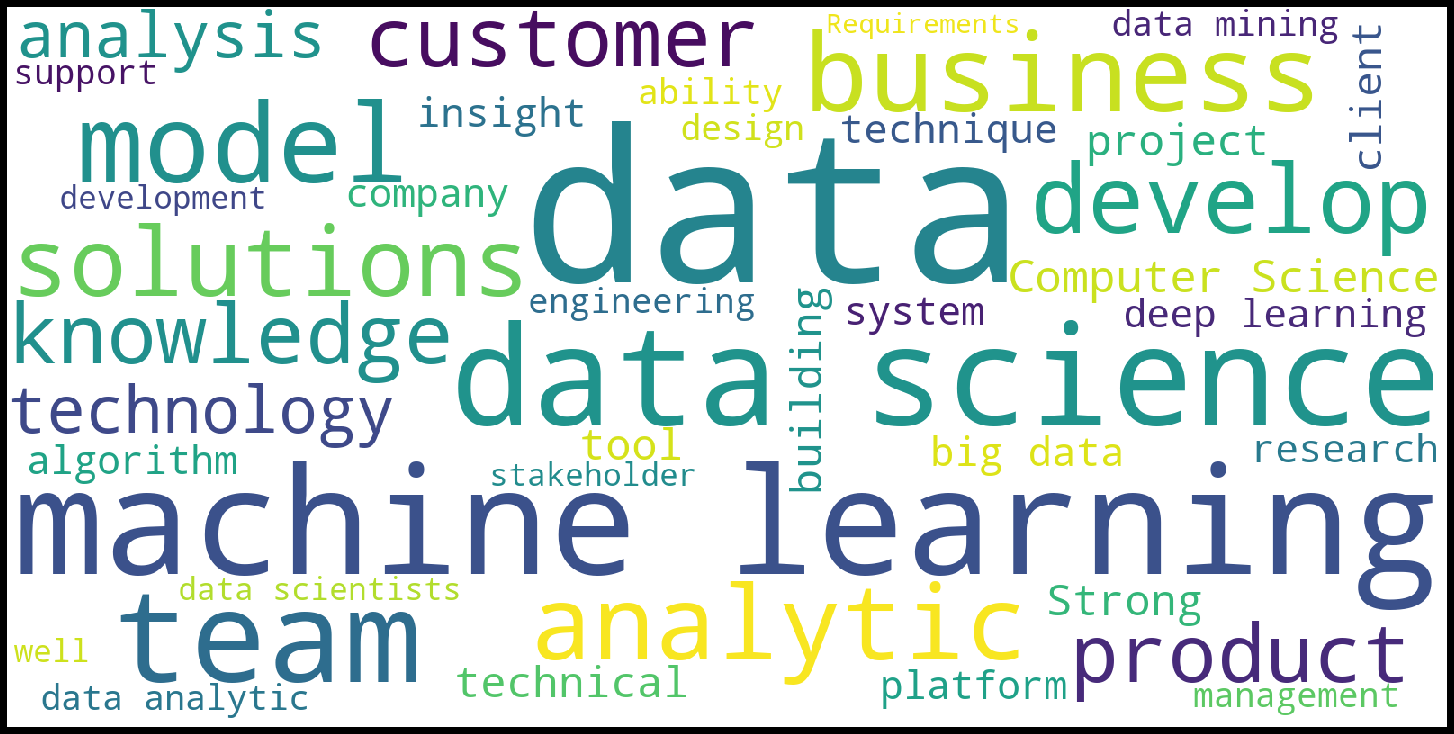

In [36]:
# Keywords in 'Data Scientist' Postings
gen_wordcloud(' '.join(ds_words), words_to_exclude)

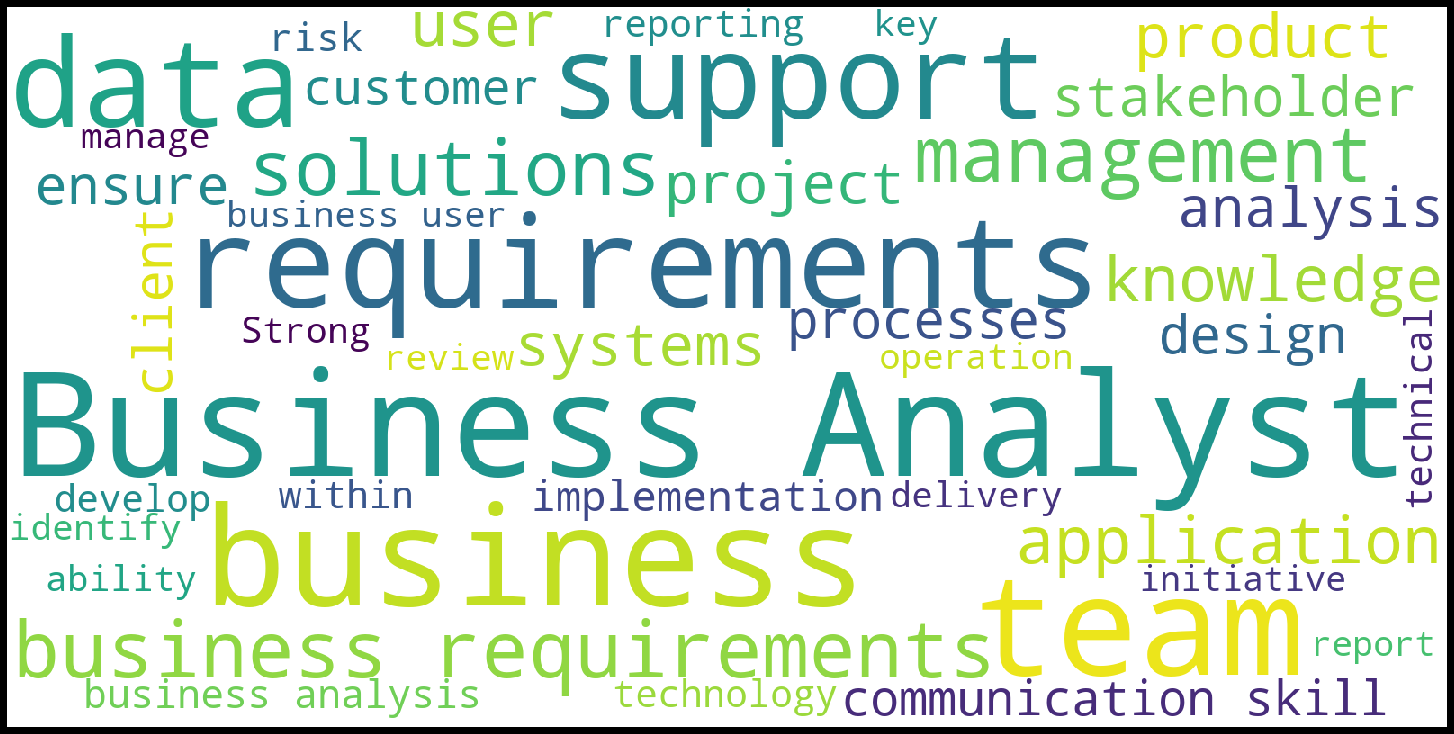

In [46]:
# Keywords in 'Business Analyst' Postings
gen_wordcloud(' '.join(ba_words), words_to_exclude)

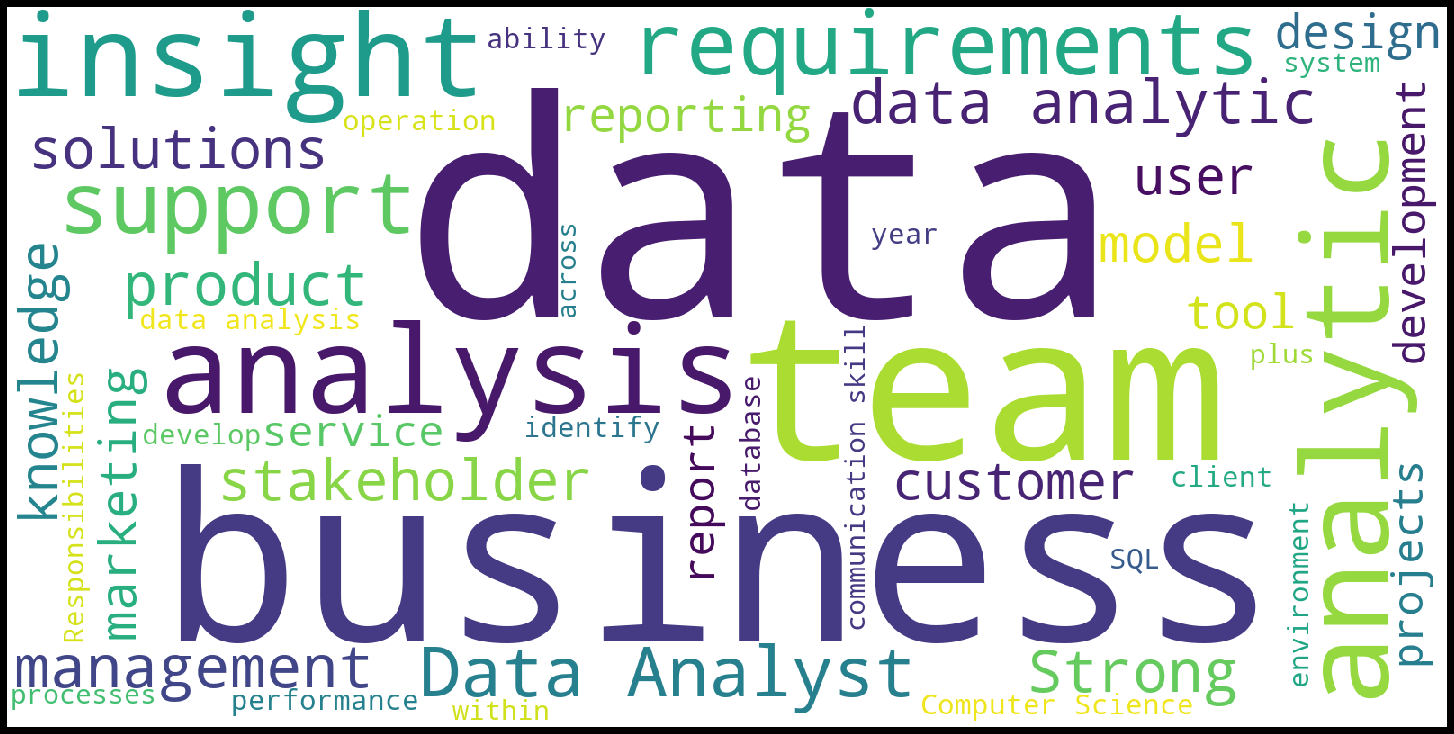

In [47]:
# Keywords in 'Data Analyst' Postings
gen_wordcloud(' '.join(da_words), words_to_exclude)

## Work Experience

In [14]:
list_of_title = ['Business Analyst',
                 'Data Analyst',
                 'Data Engineer',
                 'Data Scientist',
                 'ML Engineer', ]

In [15]:
junior_list, mid_list, senior_list = [], [], []
for title in list_of_title:
    junior_list.append(df[(df['work_exp']=='1 to 3') & (df['title_clean']==title)].shape[0])
    mid_list.append(df[(df['work_exp']=='3 to 5') & (df['title_clean']==title)].shape[0])
    senior_list.append(df[(df['work_exp']=='above 5') & (df['title_clean']==title)].shape[0])

In [237]:
import plotly.graph_objects as go

colors = ['lightslategray',] * 3
x = list_of_title
fig = go.Figure(go.Bar(x=x, y=junior_list, name='Junior (1 to 3)',
                       text=junior_list, textposition='auto',
                      marker_color='#f85f73'))
fig.add_trace(go.Bar(x=x, y=mid_list, name='Mid (3 to 5)',
                     text=mid_list, textposition='auto',
                      marker_color='#283c63'))
fig.add_trace(go.Bar(x=x, y=senior_list, name='Senior (>5)',
                     text=senior_list, textposition='auto',
                      marker_color='#928a97'))

fig.update_layout(barmode='stack',
                  xaxis={'categoryorder': 'array',
                         'categoryarray': list_of_title},
                  plot_bgcolor='white',
                  title={'text': 'Required Work Experience',
                         'font': dict(family='Arial',
                                      size=30,
                                      color='rgb(37,37,37)'), })
fig.show()

## Industry

In [17]:
df_temp = df[df['industry']!='empty']

In [18]:
df_temp['industry'].value_counts().sort_values()

Construction, Repair & Maintenance      3
Non-Profit                              3
Arts, Entertainment & Recreation        3
Agriculture & Forestry                  4
Aerospace & Defense                     5
Real Estate                             5
Education                               6
Oil, Gas, Energy & Utilities            9
Retail                                 13
Media                                  17
Health Care                            17
Travel & Tourism                       17
Biotech & Pharmaceuticals              21
Transportation & Logistics             22
Accounting & Legal                     26
Insurance                              34
Telecommunications                     52
Manufacturing                          59
Government                             80
Business Services                     184
Finance                               235
Information Technology                431
Name: industry, dtype: int64

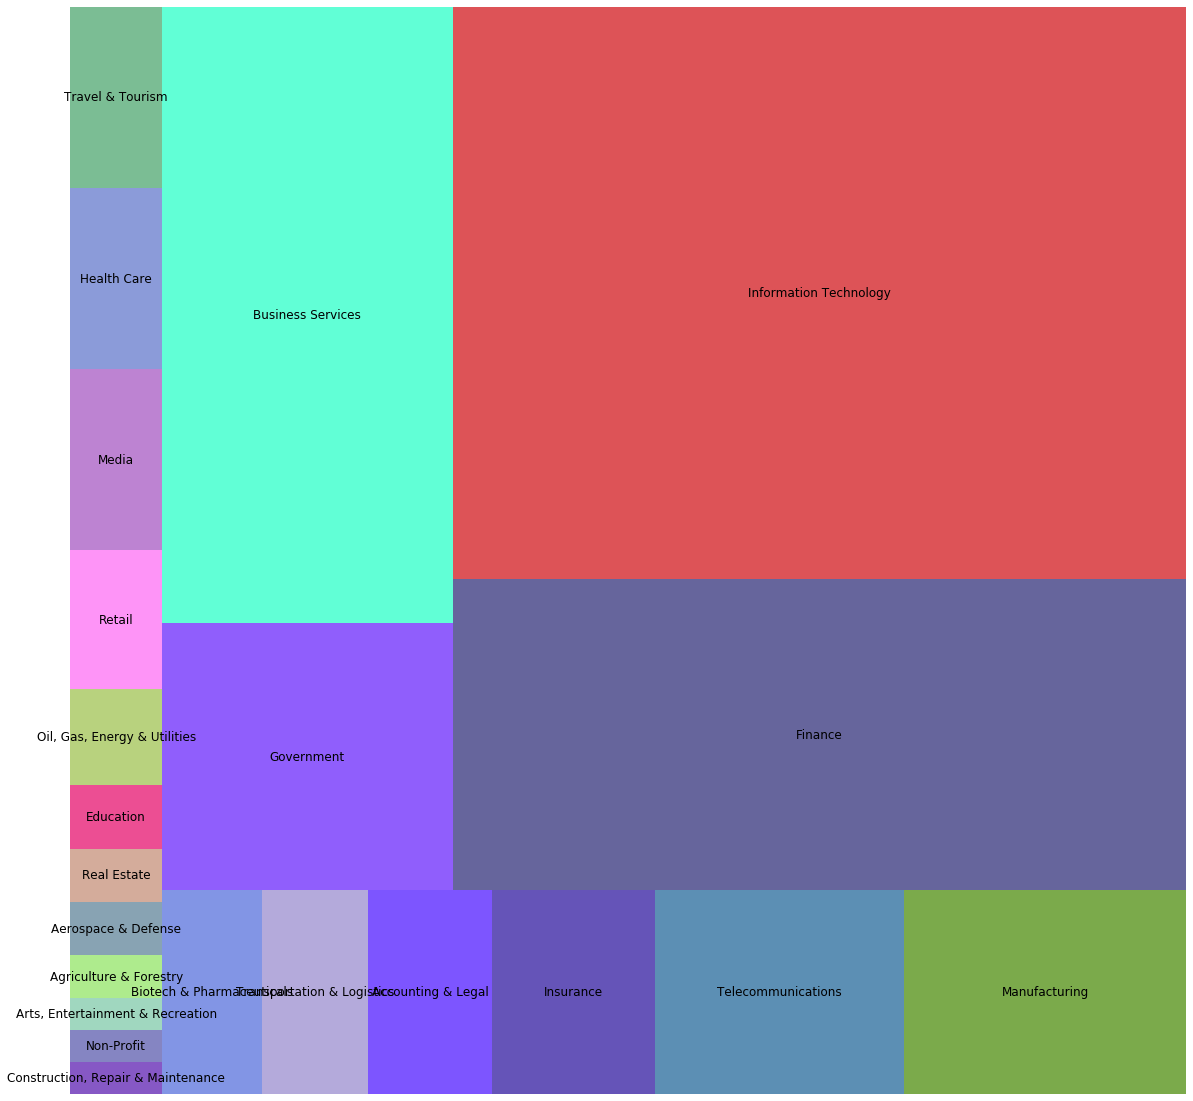

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import squarify
import random

get_colors = lambda n: list(map(lambda i: "#" + "%06x" % random.randint(0, 0xFFFFFF),range(n)))
get_colors(5) # sample return:  ['#8af5da', '#fbc08c', '#b741d0', '#e599f1', '#bbcb59', '#a2a6c0']

volume = df_temp['industry'].value_counts().sort_values().values
labels = df_temp['industry'].value_counts().sort_values().index

color_list = get_colors(len(volume))
plt.figure(figsize = (20, 20)) 

plt.rc('font', size=12)
squarify.plot(sizes=volume, label=labels,
              color=color_list, alpha=0.7)
plt.axis('off')

plt.show()

## Date Posted

In [20]:
list_of_date = list(df['date_posted'].value_counts().index.sort_values())

In [21]:
ds_list, ba_list, da_list = [], [], []
for date in list_of_date:
    ds_list.append(df[(df['title_clean']=='Data Scientist') & (df['date_posted']==date)].shape[0])
    ba_list.append(df[(df['title_clean']=='Business Analyst') & (df['date_posted']==date)].shape[0])
    da_list.append(df[(df['title_clean']=='Data Analyst') & (df['date_posted']==date)].shape[0])

In [22]:
import plotly.graph_objects as go
import numpy as np

title = 'Job Postings in November'
labels = ['Data Scientist', 'Business Analyst', 'Data Analyst']
colors = ['#e25822', '#3c9d9b', '#10316b']

mode_size = [8, 8, 8]
line_size = [2, 2, 2]

x_data = np.vstack(([str(x.date()) for x in list_of_date],)*3)

y_data = np.array([
    ds_list,
    ba_list,
    da_list,
])

fig = go.Figure()

for i in range(0, 3):
    fig.add_trace(go.Scatter(x=x_data[i], y=y_data[i], mode='lines',
        name=labels[i],
        line=dict(color=colors[i], width=line_size[i]),
        connectgaps=True,
    ))

#     # endpoints
#     fig.add_trace(go.Scatter(
#         x=[x_data[i][0], x_data[i][-1]],
#         y=[y_data[i][0], y_data[i][-1]],
#         mode='markers',
#         marker=dict(color=colors[i], size=mode_size[i])
#     ))

fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=False,
        showticklabels=True,
        linecolor='rgb(204, 204, 204)',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Arial',
            size=12,
            color='rgb(82, 82, 82)',
        ),
    ),
    yaxis=dict(
        showgrid=False,
        zeroline=False,
        showline=False,
        showticklabels=True,
    ),
    autosize=False,
    margin=dict(
        autoexpand=False,
        l=120,
        r=160,
        t=110,
    ),
    width=900,
    height=600,
    showlegend=True,
    plot_bgcolor='white'
)

annotations = []

# # Adding labels
# for y_trace, label, color in zip(y_data, labels, colors):
#     # labeling the left_side of the plot
#     annotations.append(dict(xref='paper', x=0.05, y=y_trace[0],
#                                   xanchor='right', yanchor='middle',
#                                   text=label + ' {}'.format(y_trace[0]),
#                                   font=dict(family='Arial',
#                                             size=12),
#                                   showarrow=True))
#     # labeling the right_side of the plot
#     annotations.append(dict(xref='paper', x=0.95, y=y_trace[11],
#                                   xanchor='left', yanchor='middle',
#                                   text='{}'.format(y_trace[11]),
#                                   font=dict(family='Arial',
#                                             size=16),
#                                   showarrow=False))
# Title
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Job Postings in November',
                              font=dict(family='Arial',
                                        size=30,
                                        color='rgb(37,37,37)'),
                              showarrow=False))
# # Source
# annotations.append(dict(xref='paper', yref='paper', x=0.5, y=-0.1,
#                               xanchor='center', yanchor='top',
#                               text='Source: PewResearch Center & ' +
#                                    'Storytelling with data',
#                               font=dict(family='Arial',
#                                         size=12,
#                                         color='rgb(150,150,150)'),
#                               showarrow=False))

fig.update_layout(annotations=annotations)

fig.show()
# py.iplot(fig)

## Skills

In [177]:
def generate_skill_count(title_clean):
    nodup_skill_list = []
    skill_list = list(set(df[df['title_clean']==title_clean]['skill_clean'].value_counts().index.values))
    for x in skill_list:
        for skill in x.split(','):
            nodup_skill_list.append(skill)
    nodup_skill_list = list(set(nodup_skill_list))
    skill_count_dict = {i:0 for i in nodup_skill_list}

    df_temp = df[df['title_clean']==title_clean]
    for index in df_temp.index:
        curr_skill = df_temp.loc[index]['skill_clean']
        for key in skill_count_dict.keys():
            if key in curr_skill:
                skill_count_dict[key] += 1
    return skill_count_dict

In [179]:
generate_skill_count('Business Analyst')

{'statistics': 25,
 'others': 92,
 'excel': 258,
 'machine learning': 9,
 'tableau': 41,
 'linux': 4,
 'development': 249,
 'sql': 130,
 'math': 31,
 'python': 36}

In [234]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

labels = list(generate_skill_count('Data Scientist').keys())

fig = make_subplots(1, 3, specs=[[{'type': 'domain'}, {'type': 'domain'}, {'type': 'domain'}]],
                    subplot_titles=['Data Scientist', 
                                    'Business Analyst', 
                                    'Data Analyst'])
fig.add_trace(go.Pie(labels=labels, values=list(generate_skill_count('Data Scientist').values()),
                     scalegroup='one',
                     name="Data Scientist"), 1, 1)
fig.add_trace(go.Pie(labels=labels, values=list(generate_skill_count('Business Analyst').values()), 
                     scalegroup='two',
                     name="Business Analyst"), 1, 2)
fig.add_trace(go.Pie(labels=labels, values=list(generate_skill_count('Data Analyst').values()), 
                     scalegroup='three',
                     name="Data Analyst"), 1, 3)


fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=False,
        showticklabels=True,
        linecolor='rgb(204, 204, 204)',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Arial',
            size=12,
            color='rgb(82, 82, 82)',
        ),
    ),
    yaxis=dict(
        showgrid=False,
        zeroline=False,
        showline=False,
        showticklabels=True,
    ),
    autosize=True,
    margin=dict(
        autoexpand=False,
        l=20,
        r=160,
        t=110,
    ),
    width=900,
    height=600,
    showlegend=True,
    plot_bgcolor='white'
)
fig.update_layout(title={'text': 'Required Skills',
                         'font': dict(family='Arial',
                                      size=30,
                                      color='rgb(37,37,37)'), })

# fig.update_layout(annotations=annotations)
fig.show()

# Export to HTML

In [236]:
!jupyter nbconvert --to html_toc gd_data_jobs_analysis.ipynb


[NbConvertApp] Converting notebook gd_data_jobs_analysis.ipynb to html_toc
[NbConvertApp] Support files will be in gd_data_jobs_analysis_files/
[NbConvertApp] Making directory gd_data_jobs_analysis_files
[NbConvertApp] Making directory gd_data_jobs_analysis_files
[NbConvertApp] Making directory gd_data_jobs_analysis_files
[NbConvertApp] Making directory gd_data_jobs_analysis_files
[NbConvertApp] Writing 3689985 bytes to gd_data_jobs_analysis.html
